In [2]:
from firedrake import *
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.animation import FuncAnimation

mesh = UnitSquareMesh(40, 40, quadrilateral=True)

V = FunctionSpace(mesh, "DQ", 1)
W = VectorFunctionSpace(mesh, "CG", 1)

x, y = SpatialCoordinate(mesh)

velocity = as_vector(( (0.5 - y ) , ( x - 0.5) ))
u = Function(W).interpolate(velocity)


bell_r0 = 0.15; bell_x0 = 0.25; bell_y0 = 0.5
cone_r0 = 0.15; cone_x0 = 0.5; cone_y0 = 0.25
cyl_r0 = 0.15; cyl_x0 = 0.5; cyl_y0 = 0.75
slot_left = 0.475; slot_right = 0.525; slot_top = 0.85

bell = 0.25*(1+cos(math.pi*min_value(sqrt(pow(x-bell_x0, 2) + pow(y-bell_y0, 2))/bell_r0, 1.0)))
cone = 1.0 - min_value(sqrt(pow(x-cone_x0, 2) + pow(y-cone_y0, 2))/cyl_r0, 1.0)
slot_cyl = conditional(sqrt(pow(x-cyl_x0, 2) + pow(y-cyl_y0, 2)) < cyl_r0,
             conditional(And(And(x > slot_left, x < slot_right), y < slot_top),
               0.0, 1.0), 0.0)
#+ bell + cone + slot_cyl
q = Function(V).interpolate(1.0 + bell + cone + slot_cyl)
q_init = Function(V).assign(q)

qs = []

T = 2*math.pi
dt = T/36000
dtc = Constant(dt)
q_in = Constant(1.0)

dq_trial = TrialFunction(V)
phi = TestFunction(V)
a = phi*dq_trial*dx

n = FacetNormal(mesh)
un = 0.5*(dot(u, n) + abs(dot(u, n)))

L1 = dtc*(q*div(phi*u)*dx
          - conditional(dot(u, n) < 0, phi*dot(u, n)*q_in, 0.0)*ds
          - conditional(dot(u, n) > 0, phi*dot(u, n)*q, 0.0)*ds
          - (phi('+') - phi('-'))*(un('+')*q('+') - un('-')*q('-'))*dS)


q1 = Function(V); q2 = Function(V)
L2 = replace(L1, {q: q1}); L3 = replace(L1, {q: q2})

dq = Function(V)

params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
prob1 = LinearVariationalProblem(a, L1, dq)
solv1 = LinearVariationalSolver(prob1, solver_parameters=params)
prob2 = LinearVariationalProblem(a, L2, dq)
solv2 = LinearVariationalSolver(prob2, solver_parameters=params)
prob3 = LinearVariationalProblem(a, L3, dq)
solv3 = LinearVariationalSolver(prob3, solver_parameters=params)


#Set Kuzmin limiter
limiter = VertexBasedLimiter(V)

t = 0.0
step = 0
output_freq = 20


if step % output_freq == 0:
    qs.append(q.copy(deepcopy=True))
    print("t=", t)

#Apply the limiter to q first.
limiter.apply(q)
print(q.dat.data.max())

indicator = Function(V)



#Main body



#nsp = 16
#fn_plotter = FunctionPlotter(mesh, num_sample_points=nsp)

#fig, axes = plt.subplots()
#axes.set_aspect('equal')
#colors = tripcolor(q_init, num_sample_points=nsp, vmin=1, vmax=2, axes=axes)
#fig.colorbar(colors)

#def animate(q):
    #colors.set_array(fn_plotter(q))

#interval = 1e3 * output_freq * dt
#animation = FuncAnimation(fig, animate, frames=qs, interval=interval)
#try:
    #animation.save("DG_advection_oscillating1.mp4", writer="ffmpeg")
#except:
    #print("Failed to write movie! Try installing `ffmpeg`.")

t= 0.0
2.0


2.0007870509115815
2.0015512934534803
2.002292990174189
2.0030123993336497
2.0037097750234674
2.0043853672777368
2.005039422178293
2.0056721819555547
2.006283885085474
2.006874766382901
2.0074450570915943
2.0079949849710625
2.008524774380415
2.0090346463593693
2.009524818706568
2.0099955060553354
2.0104469199470048
2.010879268901942
2.0112927584883797
2.0116875913891716
t= 0.0034906585039886587
2.0120639674665783
2.012422083825186
2.012762134873057
2.0130843123812134
2.0133888055415428
2.013675801023226
2.0139454830277796
2.0141980333428
2.0144336313945104
2.014652454299206
2.0148546769136915
2.015040169569157
2.0152082965026947
2.0153600912299527
2.015495909148103
2.0156159806193497
2.0157204929488297
2.0158686503261234
2.016080667035548
2.016282882890572
t= 0.0069813170079773106
2.0164753516695035
2.0166581269692467
2.0168312622052316
2.016994810611343
2.0171488252398637
2.017293358961425
2.01742846446496
2.0175541942576736
2.0176706006650136
2.0177777358306526
2.017875651716477
2.01

KeyboardInterrupt: 

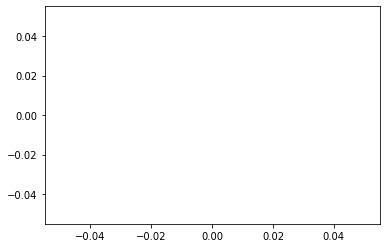

In [3]:

while t < T - 0.5*dt:
    solv1.solve()
    q1.assign(q + dq)
    limiter.apply(q1)

    solv2.solve()
    q1.assign(q1+dq)
    limiter.apply(q1)
    q2.assign(0.75*q + 0.25*(q1))
    limiter.apply(q2)

    solv3.solve()
    q2.assign(q2+dq)
    limiter.apply(q2)
    q.assign((1.0/3.0)*q + (2.0/3.0)*(q2))
    limiter.apply(q)
    indicator.interpolate(conditional(q>2, 1, 0))
    


    print(q.dat.data.max())
    step += 1
    t += dt

    if step % output_freq == 0:
        qs.append(q.copy(deepcopy=True))
        print("t=", t)



L2_err = sqrt(assemble((q - q_init)*(q - q_init)*dx))
L2_init = sqrt(assemble(q_init*q_init*dx))
print(L2_err/L2_init)